# 0. Load the packages

In [44]:
# basics
import os
import numpy as np
import pandas as pd
from collections import Counter

# for data standardization
from sklearn.preprocessing import StandardScaler

# for PCA decomposition
from sklearn.decomposition import PCA

# for clustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram

# for spatial analysis
import geopandas as gpd

# for visualization
import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
# Specify the path
project_path = r'D:\Projects\count_tweet\poi_clustering'
data_path = os.path.join(project_path, 'data')
figure_path = os.path.join(project_path, 'figures')

In [3]:
# Function to setup the axis
def setup_axis(ax) -> None:
    """
    Set up the axis in the subplots of matplotlib, including:
        - spines
        - xtick and ytick sizes
    :param ax: a subplot axis
    :return: None. The axis is reformatted
    """
    # set the figure's right and top spines to invisible
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
# Set the font type
font = {'family': 'serif'}
mpl.rc('font', **font)

# 1. Load the data

### Load the POI data

In [4]:
poi_data = pd.read_csv(os.path.join(data_path, 'RESULTS_POI.csv'), encoding='utf-8')
poi_shapefile = gpd.read_file(os.path.join(data_path, 'RESULTS_POI.shp'), encoding='utf-8')

In [5]:
poi_shapefile_4326 = poi_shapefile.to_crs(epsg=4326)

In [6]:
poi_data.columns

Index(['ID_UNIQ', 'TW_ACTIVIT', '3D', '2D', '2C', '2A', '2E', '2F', '3E', '4B',
       '2B', '3C', '3B', '4A', '1C', '4C', '3A', '1A', '1B', 'PCA1', 'PCA2a',
       'PCA2b', 'SENTIMENT', 'sentiment_'],
      dtype='object')

In [7]:
select_columns = ['TW_ACTIVIT', '3D', '2D', '2C', '2A', '2E', '2F', '3E', '4B',
       '2B', '3C', '3B', '4A', '1C', '4C', '3A', '1A', '1B', 'SENTIMENT']

In [8]:
poi_select = poi_data[select_columns].copy()

In [9]:
poi_select['id'] = list(range(poi_select.shape[0]))

In [10]:
poi_select

,TW_ACTIVIT,3D,2D,2C,2A,2E,2F,3E,4B,2B,3C,3B,4A,1C,4C,3A,1A,1B,SENTIMENT,id
0,217.0,2.438,102,80,0.06256,0.15166,0.85687,5.11279,0.4777,0.0398,1.1052,0.2617,2.4211,4.3507,0.460,29.88499,0.584515,0.45388,1.562212,0
1,40.0,11.490,665,732,0.91132,1.67609,5.50912,22.18760,1.2365,0.0092,0.4602,0.0562,0.6120,4.1807,0.443,58.66411,0.429222,0.55778,1.650000,1
2,31.0,3.591,217,193,0.16793,0.34479,1.28271,8.57878,1.2577,0.0143,0.0840,0.4016,0.8700,3.4506,0.461,83.38249,0.639931,0.59269,1.580645,2
3,1771.0,8.145,1320,1186,1.14932,1.90910,2.65439,20.14532,1.2781,0.2205,2.5739,1.1107,0.2806,4.2920,0.419,200.61235,0.443443,0.88744,1.427442,3
4,1.0,2.357,61,53,0.15681,0.27704,0.59066,11.03446,1.1604,0.0052,0.2509,0.0000,4.0083,4.1248,0.416,2.95813,0.595146,0.65275,1.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,5.0,4.920,129,158,0.22209,0.45571,0.83931,4.27730,1.0960,0.0000,0.0000,0.0000,0.1634,2.3560,0.447,132.60549,0.343469,0.40165,1.400000,812
813,14.0,0.000,29,22,0.09215,0.10670,0.07760,0.26675,1.1349,0.0000,0.0000,0.0000,291.9466,2.0000,0.443,0.90453,0.184808,0.01181,1.428571,813
814,8.0,1.303,57,54,0.15483,0.18176,0.15483,0.99293,0.6328,0.0000,0.0000,0.0000,200.1365,4.0844,0.416,6.05734,0.181315,0.38068,1.750000,814
815,106.0,11.583,965,1044,0.81645,1.53030,4.50735,19.10970,1.2606,0.0088,0.3064,0.1123,0.4009,4.2138,0.444,91.93310,0.364122,0.52901,1.566038,815


In [11]:
poi_data.head()

,ID_UNIQ,TW_ACTIVIT,3D,2D,2C,2A,2E,2F,3E,4B,...,1C,4C,3A,1A,1B,PCA1,PCA2a,PCA2b,SENTIMENT,sentiment_
0,0,217.0,2.438,102,80,0.06256,0.15166,0.85687,5.11279,0.4777,...,4.3507,0.460,29.88499,0.584515,0.45388,2.585340,2.585340,-0.299136,1.562212,1.562212
1,1,40.0,11.490,665,732,0.91132,1.67609,5.50912,22.18760,1.2365,...,4.1807,0.443,58.66411,0.429222,0.55778,-2.832431,-2.832431,-1.222037,1.650000,1.650000
2,2,31.0,3.591,217,193,0.16793,0.34479,1.28271,8.57878,1.2577,...,3.4506,0.461,83.38249,0.639931,0.59269,1.239093,1.239093,-0.638925,1.580645,1.580645
3,3,1771.0,8.145,1320,1186,1.14932,1.90910,2.65439,20.14532,1.2781,...,4.2920,0.419,200.61235,0.443443,0.88744,-4.821418,-4.821418,0.687961,1.427442,1.427442
4,4,1.0,2.357,61,53,0.15681,0.27704,0.59066,11.03446,1.1604,...,4.1248,0.416,2.95813,0.595146,0.65275,1.991075,1.991075,-1.366796,1.000000,1.000000


### Load the city border

In [12]:
tricity_border = gpd.read_file(os.path.join(data_path, 'tricity_border.shp'), encoding='utf-8')

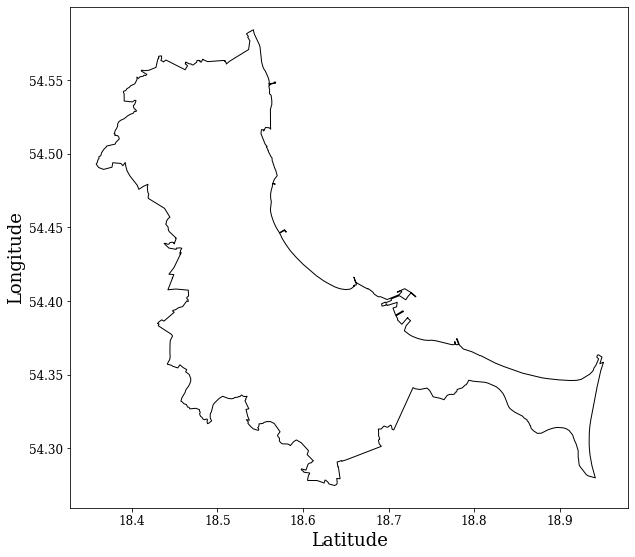

In [13]:
tricity_figure, tricity_axis = plt.subplots(1, 1, figsize=(10, 17))
tricity_border.plot(ax = tricity_axis, color='white', edgecolor='black', zorder=1)
tricity_axis.set_xlabel('Latitude', size=18)
tricity_axis.set_ylabel('Longitude', size=18)
tricity_axis.tick_params(axis="x", labelsize=12)
tricity_axis.tick_params(axis="y", labelsize=12)

# 2. Use PCA to select the number of factors

reference papers: 

1. [The varimax criterion for analytic rotation in factor analysis](https://link.springer.com/article/10.1007/BF02289233)
2. [Big location-based social media messages from China's Sina Weibo network: Collection, storage, visualization, and potential ways of analysis](https://onlinelibrary.wiley.com/doi/abs/10.1111/tgis.12266)
3. [Understanding the impact of built environment on metro ridership using open source in Shanghai](https://www.sciencedirect.com/science/article/abs/pii/S0264275118307261)

In [14]:
data_to_cluster = poi_select[select_columns].to_numpy()

In [15]:
data_to_cluster

array([[2.170000e+02, 2.438000e+00, 1.020000e+02, ..., 5.845150e-01,
        4.538800e-01, 1.562212e+00],
       [4.000000e+01, 1.149000e+01, 6.650000e+02, ..., 4.292220e-01,
        5.577800e-01, 1.650000e+00],
       [3.100000e+01, 3.591000e+00, 2.170000e+02, ..., 6.399310e-01,
        5.926900e-01, 1.580645e+00],
       ...,
       [8.000000e+00, 1.303000e+00, 5.700000e+01, ..., 1.813150e-01,
        3.806800e-01, 1.750000e+00],
       [1.060000e+02, 1.158300e+01, 9.650000e+02, ..., 3.641220e-01,
        5.290100e-01, 1.566038e+00],
       [3.000000e+00, 7.590000e-01, 2.900000e+01, ..., 5.101980e-01,
        6.844600e-01, 2.000000e+00]])

### First, we need to standardize the data

In [16]:
scaler = StandardScaler()

In [17]:
scaler.fit(data_to_cluster)

StandardScaler()

In [18]:
standard_data = scaler.transform(data_to_cluster)

In [19]:
standard_data.shape

(817, 19)

### Next, use the PCA to do dimensionality reduction

In [20]:
# If n_components=None, n_components = min(n_samples, n_features)
pca = PCA(n_components=None, svd_solver='full')

In [21]:
pca_result = pca.fit(standard_data)

In [22]:
pca_result.explained_variance_ratio_

array([4.95521124e-01, 1.09449233e-01, 8.18041949e-02, 5.49918157e-02,
       4.82885892e-02, 4.19566399e-02, 3.94229962e-02, 3.17117294e-02,
       2.22978685e-02, 2.05345265e-02, 1.72302008e-02, 1.20092772e-02,
       8.91714435e-03, 5.66971040e-03, 4.61464655e-03, 3.55190187e-03,
       1.76841455e-03, 2.04511766e-04, 5.54753044e-05])

In [23]:
# Almost all the factor's singular values are greater than 1
pca_result.singular_values_

array([87.70390185, 41.21869051, 35.63490589, 29.21708329, 27.37852753,
       25.52044124, 24.73788937, 22.18695959, 18.60456431, 17.85377986,
       16.35433908, 13.65357132, 11.76523828,  9.38141325,  8.46363742,
        7.42537357,  5.23937965,  1.78175087,  0.92797799])

In [24]:
pca_result.n_components_

19

In [25]:
def plot_variance_increment(explained_variance_ratio):
    """
    Plot the incremental variance based on the PCA explained variance
    :param explained_variance_ratio: the PCA explained variance ratio
    :return: a figure showing the incremental variance of factors
    """
    # Compute the incremental explained variance
    increment_variances = [0]
    for index, variance in enumerate(explained_variance_ratio):
        if index - 1>=0:
            increment_variances.append(variance + increment_variances[index])
        else:
            increment_variances.append(variance)
    xticks = list(range(len(increment_variances)))
    yticks = np.arange(0, 1.2, 0.2)
    
    # Draw the line graph finding the best number of PCA components
    figure, axis = plt.subplots(1, 1, figsize=(10, 8))
    axis.plot(xticks, increment_variances)
    axis.axhline(0.8, color='black', linestyle='--')
    axis.axvline(5, color='red', linestyle='--')
    
    # Setup the axis
    axis.set_xticks(xticks)
    axis.set_yticks(yticks)
    axis.set_yticklabels([str(int(val * 100))+'%' for val in yticks])
    axis.tick_params(axis="x", labelsize=12)
    axis.tick_params(axis="y", labelsize=12)
    axis.set_xlabel('Considered Number of PCA Components', size=18)
    axis.set_ylabel('Explained Variance', size=18)
    setup_axis(axis)
    
    # Save the figure and draw the plot
    figure.savefig(os.path.join(figure_path, 'variance_increment.png'))
    plt.show()

We plot the explained variance against the number of considered PCA components.

We find that the first five principal components accounting for 80% of the data.

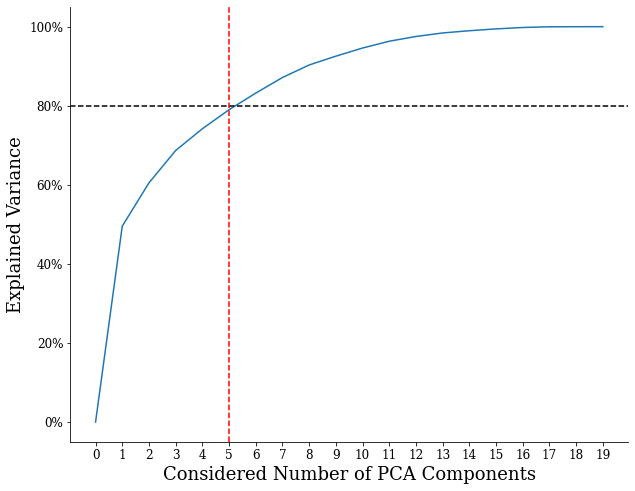

In [26]:
plot_variance_increment(pca_result.explained_variance_ratio_)

### Get the principal components

In [27]:
principalComponents = PCA(n_components=5).fit_transform(standard_data)

In [28]:
principal_component_data = pd.DataFrame(principalComponents, 
                                        columns=['Principal_{}'.format(str(val)) for val in list(range(5))])

In [29]:
principal_component_data

,Principal_0,Principal_1,Principal_2,Principal_3,Principal_4
0,2.539868,-0.516003,-0.448185,0.696056,0.425502
1,-2.548978,-1.582170,1.528073,-0.196597,1.195110
2,1.328425,-0.943537,-0.517094,0.505293,0.903682
3,-5.070868,0.730654,-0.243564,0.012407,-0.393541
4,2.181181,-1.016311,0.255409,-0.393432,-0.471663
...,...,...,...,...,...
812,1.761130,0.449532,1.310784,0.311802,0.337041
813,4.339448,4.549297,7.012423,-0.792048,7.094160
814,3.664263,2.502303,4.825279,-1.288665,4.723949
815,-2.604876,-1.007138,1.738452,-0.258138,0.984731


### Compute the correlation between principal components and data

In [30]:
def compute_corr_dataframes(standard_data, principal_data):
    """
    Compute the correlation dataframe
    :param standard_data: the standardized data based on features
    :param principal_data: the principal components
    :param select_columns: the columns for correlation computation
    :return: a dataframe saving the correlation between data and principal component
    """
    components_num = principal_data.shape[1]
    principal_component_dataframe = pd.DataFrame(principal_data, 
                                        columns=['Principal_{}'.format(str(val)) for val in list(range(components_num))])
    standard_dataframe = pd.DataFrame(standard_data, columns=select_columns)
    correlations = []
    for principal_name in principal_component_dataframe.columns:
        principal_correlations = []
        for data_name in standard_dataframe.columns:
            correlation = np.corrcoef(principal_component_dataframe[principal_name], standard_dataframe[data_name])[0, 1]
            principal_correlations.append(correlation)
        correlations.append(principal_correlations)
    result_array = np.array(correlations).T
    result_dataframe = pd.DataFrame(result_array, 
                                    columns=['Principal_{}_corr'.format(str(val)) for val in list(range(components_num))], 
                                    index=select_columns)
    return result_dataframe

In [31]:
corr_dataframe = compute_corr_dataframes(standard_data, principalComponents)
corr_dataframe

,Principal_0_corr,Principal_1_corr,Principal_2_corr,Principal_3_corr,Principal_4_corr
TW_ACTIVIT,-0.883779,0.254235,-0.045203,-0.043025,-0.020210
3D,-0.642438,-0.485120,0.300211,0.107265,-0.088828
2D,-0.974933,0.130061,0.004568,-0.055603,0.034648
2C,-0.975883,0.088509,0.018967,-0.064500,0.045419
2A,-0.972886,0.089670,0.042815,-0.054159,0.039727
2E,-0.982079,0.061258,0.040609,-0.058166,0.053537
2F,-0.888476,-0.142916,0.079900,-0.050621,0.104408
3E,-0.841581,-0.012763,-0.111660,-0.093556,0.082513
4B,-0.749490,-0.232482,0.288535,0.112990,0.046070
2B,-0.854217,0.252210,-0.046899,0.139595,-0.103051


In [32]:
# Save the correlation to the local directory
corr_dataframe.to_excel(os.path.join(data_path, 'corr_data.xlsx'))

### Get the transformed data for clustering

In [33]:
transformed_data = PCA(n_components=5).fit_transform(standard_data)

In [34]:
transformed_data.shape

(817, 5)

# 3. Clustering analysis

### Hierarchical clustering

In [35]:
def draw_dendrogram(data, color_threshold_val: float):
    # Plot the dendrogram
    figure, axis = plt.subplots(1, 1, figsize=(17, 10), dpi=200)
    axis.set_title('POI Clustering', size=20)
    axis.set_xlabel('POI places', size=18)
    axis.set_ylabel('Euclidean distances', size=18)
    dendrogram = sch.dendrogram(sch.linkage(data, method = 'ward'), 
                                color_threshold=color_threshold_val, 
                               above_threshold_color='black')
    axis.axhline(color_threshold_val, linestyle='--', color='black', alpha=0.8)
    
    # Edit the xlabels
    axis.set_xticks([])
    setup_axis(axis)
    
    figure.savefig(os.path.join(figure_path, 'dendrogram.png'), bbox_inches='tight')

We think setting the number of clusters equals 4 is appropriate.

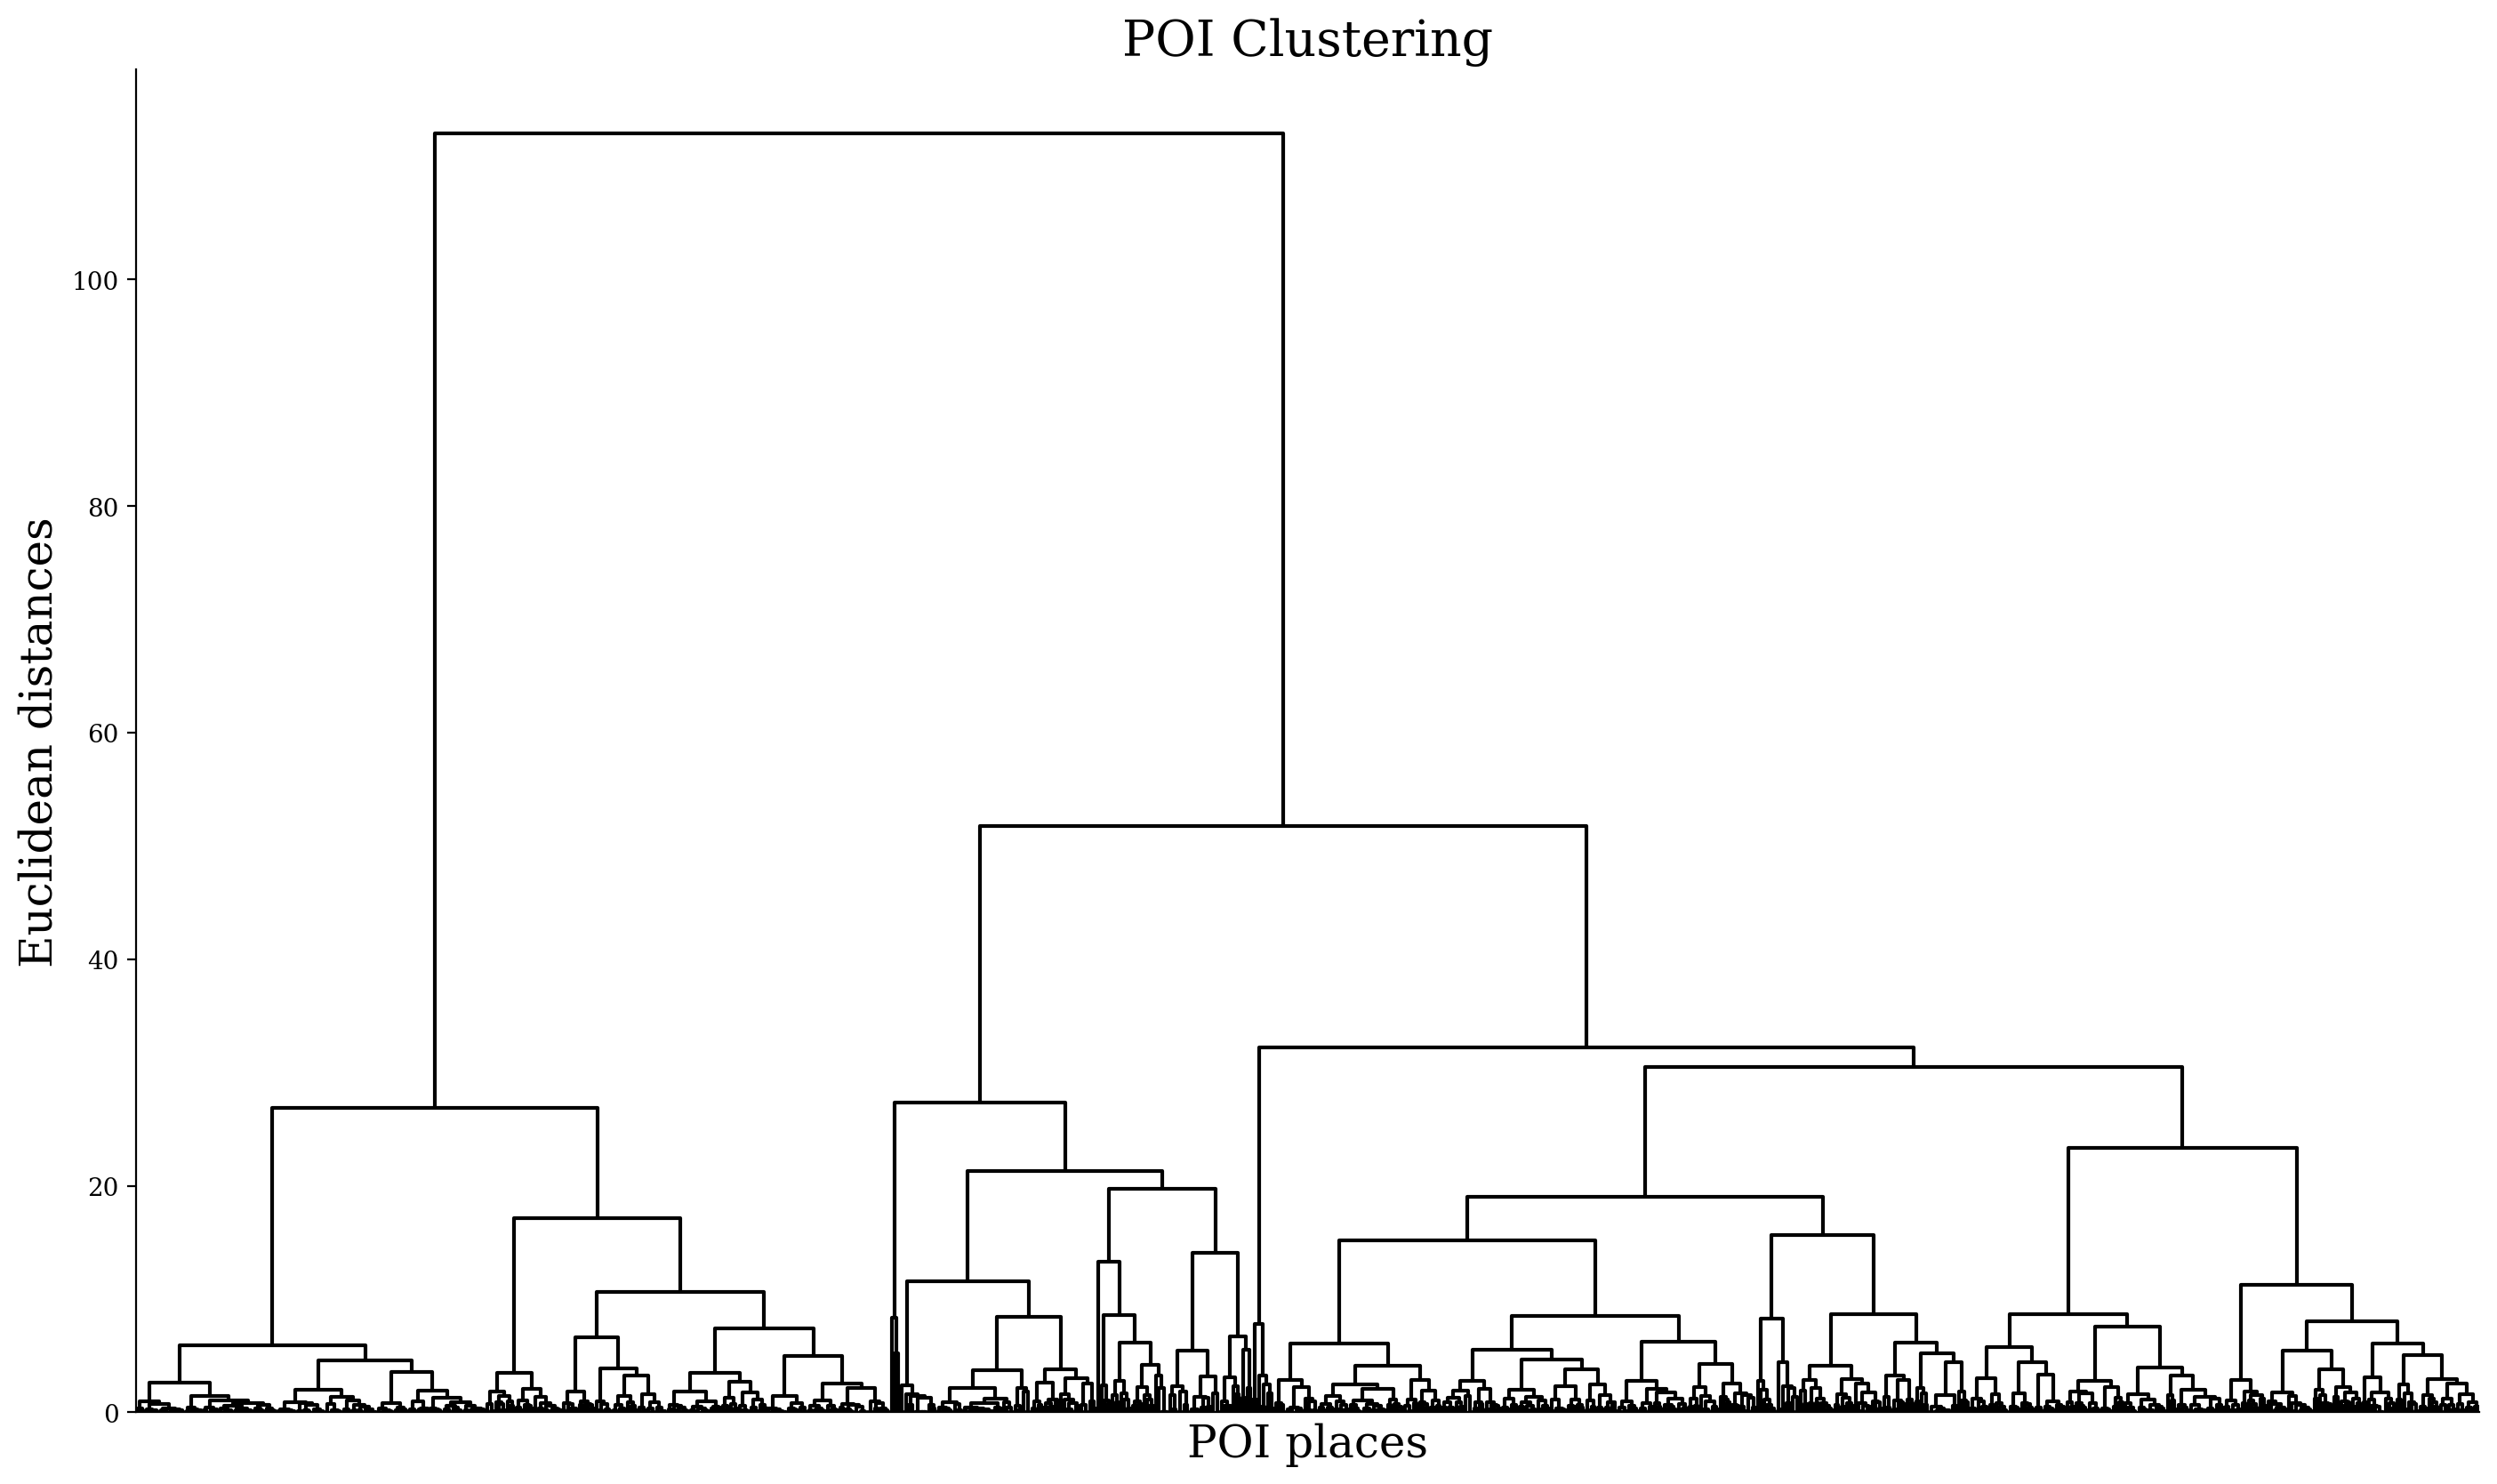

In [36]:
draw_dendrogram(data=transformed_data, color_threshold_val=0)

### Predict the labels

In [37]:
cluster_4 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
cluster_4_labels = cluster_4.fit_predict(standard_data)

In [38]:
Counter(cluster_4_labels)

Counter({3: 261, 2: 207, 1: 231, 0: 118})

### Plot the pois belonging to different clusters

In [39]:
color_dict = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}

In [40]:
poi_shapefile_4326['cluster'] = cluster_4_labels
poi_shapefile_4326['colors'] = poi_shapefile_4326.apply(lambda row: color_dict[row.cluster], axis=1)

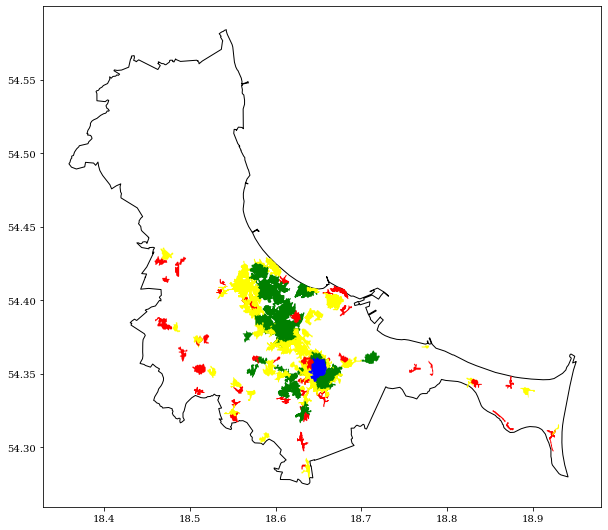

In [41]:
poi_figure, poi_axis = plt.subplots(1, 1, figsize=(10, 17))
tricity_border.plot(ax=poi_axis, color='white', edgecolor='black', linewidth=1.0, zorder=1)
poi_shapefile_4326.plot(ax=poi_axis, legend=True, color=poi_shapefile_4326['colors'],
                        categorical=True, legend_kwds={'loc': "upper left"}, zorder=2)
poi_figure.savefig(os.path.join(figure_path, 'poi_cluster.png'), bbox_inches='tight')

### Save the clustering results for the following analysis

In [42]:
combined_data = pd.concat([poi_data, principal_component_data], axis=1)
combined_data['cluster_label'] = cluster_4_labels

In [43]:
combined_data.to_excel(os.path.join(data_path, 'poi_clustering_results.xlsx'))